In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from sklearn.metrics import auc, precision_recall_curve, roc_curve, confusion_matrix, average_precision_score
import os
from tqdm import tqdm
import json

In [8]:
tick_size = 20
matplotlib.rcParams.update({
    'figure.figsize':(20,10), 
    'font.size': 25, 
    "axes.labelsize":25, 
    "xtick.labelsize": tick_size, 
    "ytick.labelsize": tick_size,
    'font.family':'serif'
})

sns.set(rc={
    'figure.figsize':(20,10), 
    'font.size': 25, 
    "axes.labelsize":25, 
    "xtick.labelsize": tick_size, 
    "ytick.labelsize": tick_size,
    'font.family':'serif',
    'grid.linestyle': '',
    'axes.facecolor': 'white',
    'axes.edgecolor': '0.2',
    'axes.spines.bottom': True,
    'axes.spines.left': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
})

palette = sns.color_palette("Set2", n_colors=6, desat=1)[::-1] # reverse for aesthetics

In [10]:
dataset_counts = [672, 500, 400, 300, 200, 100]
folds = [0, 1, 2, 3, 4]
# init stats dict
stats = {
    d:{
        f: {
            y: [] for y in ["y_true", "y_pred", "y_prob"]} 
        for f in folds} 
    for d in dataset_counts
}

# Read predictions file

In [11]:
for dataset_count in dataset_counts:
    for cur_fold in range(5):
        pred_filepath = os.path.join(
            'predictions', 
            'figure_3_dataset_{}'.format(dataset_count), 
            'model_predictions_{}_fold_{}'.format(dataset_count, cur_fold)
        )
        with open(pred_filepath, 'r') as f:
            lines = [l.strip().split(',') for l in f.readlines()]
            
        for l in lines[1:]:
            stats[dataset_count][cur_fold]["y_true"].append(int(l[0]))
            stats[dataset_count][cur_fold]["y_pred"].append(int(l[1]))
            stats[dataset_count][cur_fold]["y_prob"].append(float(l[2]))
            
        stats[dataset_count][cur_fold]["y_true"] = np.array(stats[dataset_count][cur_fold]["y_true"])
        stats[dataset_count][cur_fold]["y_pred"] = np.array(stats[dataset_count][cur_fold]["y_pred"])
        stats[dataset_count][cur_fold]["y_prob"] = np.array(stats[dataset_count][cur_fold]["y_prob"])

# Precision-Recall Curve

In [55]:
# take average of all fold stats:
dataset_count = 672
y_true = []
y_prob = []

for cur_fold in range(5):
    y_true.append(stats[dataset_count][cur_fold]["y_true"])
    y_prob.append(stats[dataset_count][cur_fold]["y_prob"])


y_true = np.array(y_true)
y_true = np.mean(y_true, axis=0)

y_prob = np.array(y_prob)
y_prob = np.mean(y_prob, axis=0)

In [56]:
# set color to match other figures:
model_672_color = palette[-1]

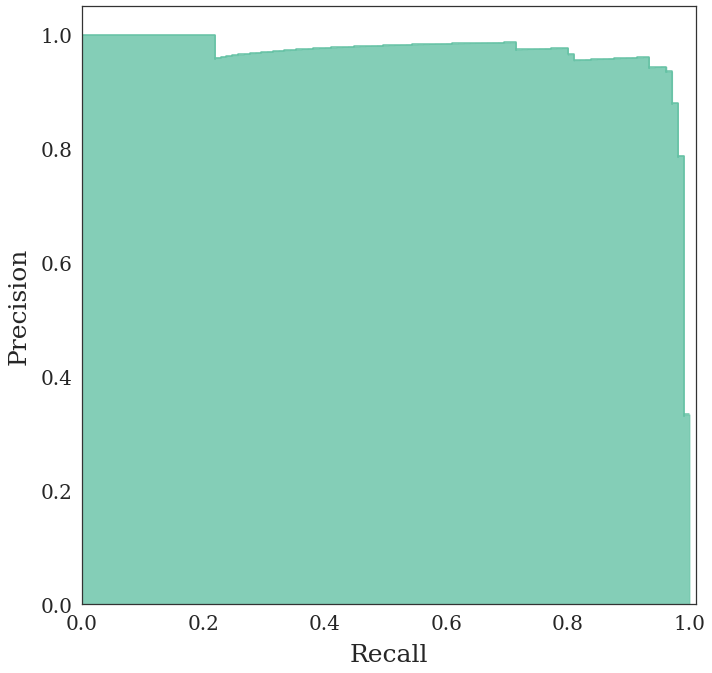

In [57]:
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

average_precision = average_precision_score(y_true, y_prob)

plt.figure(figsize=(11, 11))

step_kwargs = {'step': 'post'}
plt.step(recall, precision, color=model_672_color, alpha=1, where='post')
plt.fill_between(recall, precision, alpha=0.8, color=model_672_color, **step_kwargs)

labelpad = 10 + 10 # to match the confusion matrix with its ticklabels
plt.xlabel('Recall', labelpad=10)
plt.ylabel('Precision', labelpad=10)
plt.ylim([0, 1.05])
plt.xlim([0, 1.01])
#plt.title('Precision-Recall Curve: AP={0:0.4f}\n'.format(average_precision))
#plt.title('Precision-Recall Curve: Model 672\n'.format(dataset_count))
plt.savefig('figures/figure_3_dataset_{}/dataset_{}_PR_Curve.png'.format(dataset_count, dataset_count), bbox_inches='tight')
#plt.savefig('figures/figure_3_dataset_{}/dataset_{}_PR_Curve.eps'.format(dataset_count, dataset_count), bbox_inches='tight')

In [58]:
average_precision

0.9698347066261325

In [59]:
len(thresholds)

314

# ROC Curve

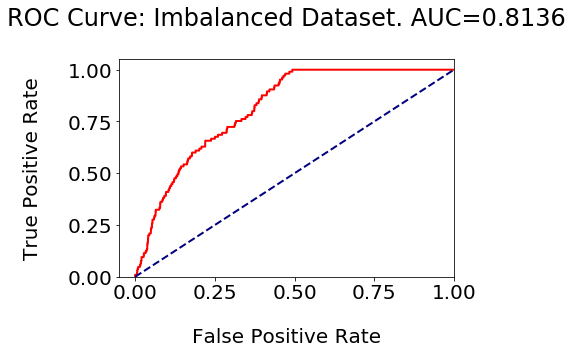

In [219]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red', lw=lw, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.ylim([0.0, 1.05])
plt.xlim([-0.05, 1.0])
plt.xlabel('False Positive Rate', labelpad=25)
plt.ylabel('True Positive Rate', labelpad=25)
plt.title('ROC Curve: Imbalanced Dataset. AUC={0:0.4f}\n'.format(roc_auc))
plt.savefig('figures/figure_3_dataset_{}/dataset_{}_ROC_Curve.png'.format(dataset_count, dataset_count), bbox_inches='tight')
plt.savefig('figures/figure_3_dataset_{}/dataset_{}_ROC_Curve.eps'.format(dataset_count, dataset_count), bbox_inches='tight')

# Confusion Matrix

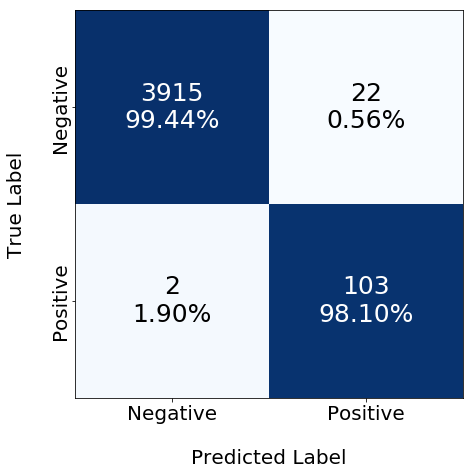

In [12]:
class_names = ['Negative', 'Positive']
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 7))
im = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=class_names,
    yticklabels=class_names,
    #title='Model {} Confusion Matrix\n'.format(dataset_count),
    ylabel='True Label',
    xlabel='Predicted Label',
)

ax.xaxis.labelpad = 25
ax.yaxis.labelpad = 25

#plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), rotation=90, ha='center', rotation_mode='anchor')

thresh = cm_norm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, "{}\n{:.2f}%".format(cm[i, j], cm_norm[i, j] * 100),
                ha="center", va="center",
                color="white" if cm_norm[i, j] > thresh else 'black',
                fontsize=25)
fig.tight_layout()
plt.savefig('figures/figure_3_dataset_{}/dataset_{}_Normalized_Confusion_Matrix.png'.format(dataset_count, dataset_count), bbox_inches='tight')
plt.savefig('figures/figure_3_dataset_{}/dataset_{}_Normalized_Confusion_Matrix.eps'.format(dataset_count, dataset_count), bbox_inches='tight')

# Find FP and FN

In [109]:
dataset_count = 672

# load model
weight_path = "/nfs/share5/remedis/projects/multiple_instance_learning/models/weights/class_resnet/dataset_{}/best_weights_fold_1.h5".format(dataset_count)
model_path = "/nfs/share5/remedis/projects/multiple_instance_learning/models/weights/class_resnet/class_resnet.json"
with open(model_path) as json_data:
    model = tf.keras.models.model_from_json(json.load(json_data))
model.load_weights(weight_path)

test_ds_filename = os.path.join(
    os.sep,
    'home',
    'remedis',
    'data',
    'dataset_fold___test.tfrecord',
)
test_dataset = tf.data.TFRecordDataset(test_ds_filename)\
    .map(lambda r: parse_bag(
        r,
        (512, 512),
        2,
    ))


wrong_x = []
wrong_true = []
wrong_pred = []
wrong_top_idx = []

for (x, y), y_true, y_pred in zip(test_dataset, y_true, y_pred):
    
    if y_true != y_pred:
        logits = model(x)
        _, top_idx = mil_prediction(tf.nn.softmax(logits))

        wrong_x.append(x.numpy())
        wrong_true.append(y_true)
        wrong_pred.append(y_pred)
        wrong_top_idx.append(top_idx)

In [110]:
fp = []
fn = []
for y_true, y_pred, x, top_idx in zip(wrong_true, wrong_pred, wrong_x, wrong_top_idx):
    if y_true == 1:
        fn.append(x[top_idx, :, :, 0].T)
    else:
        fp.append(x[top_idx, :, :, 0].T)


In [111]:
len(fn)

2

In [5]:
for a, b in zip(y_true, y_pred):
    if a!=b:
        print(a, b)

0 1
0 1
0 1
0 1
1 0
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
1 0
0 1


# Plot 2 False Negatives

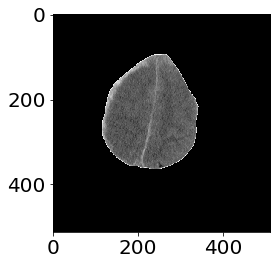

In [112]:
plt.imshow(fn[0], cmap='Greys_r')

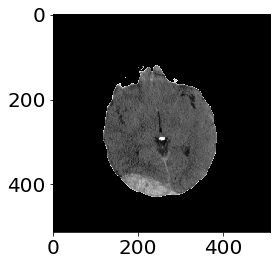

In [133]:
im = fn[1].copy()
thresh = im.max()*0.5
im[np.where(im >= thresh)] = thresh

plt.imshow(im, cmap='Greys_r')

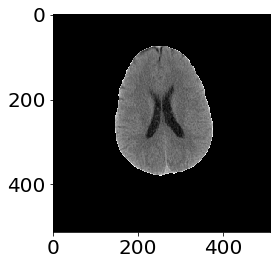

In [143]:
plt.imshow(fp[2], cmap='Greys_r')

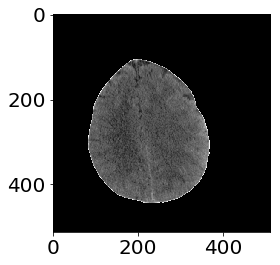

In [141]:
plt.imshow(fp[7], cmap='Greys_r')

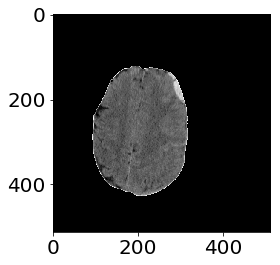

In [144]:
plt.imshow(fp[0], cmap='Greys_r')

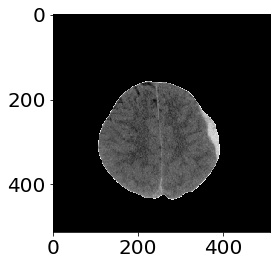

In [147]:
plt.imshow(fp[6], cmap='Greys_r')

True: 0
Pred: 1


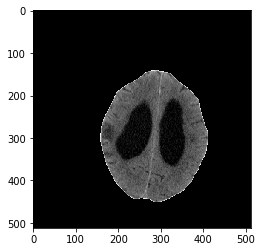

In [123]:
selected_idx = 9
plt.imshow(wrong_x[selected_idx][wrong_top_idx[selected_idx], :, :, 0].T, cmap='Greys_r')
print("True: {}\nPred: {}".format(
    y_true[wrong_idx[selected_idx]],
    y_pred[wrong_idx[selected_idx]],
))